# LB06: Знакомство за обработкой естественного языка

<div style="text-align: right"> ПСА 5 (Введение в машинное обучение). Мехмат, БГУ</div>
    
<div style="text-align: right"> Тишуров Алексей, ноябрь 2021 </div>

Данный материал использует лицензию [Creative Commons CC BY-NC-SA 4.0.](https://creativecommons.org/licenses/by-nc-sa/4.0/) со всеми вытекающими. На прилагаемый к материалу датасет лицензия не распространяется. 

Базовая оценка за работу - 8. Одно дополнительное задание превратит ее в 9. А еще одно в 10.

In [3]:
import pandas as pd
import numpy as np

В этой лабораторной работе вы будете знакомиться с NLP на примере задаче по определению "неискренних" вопросов на quora. По этой ссылке можно ознакомиться с задачей и данными https://www.kaggle.com/c/quora-insincere-questions-classification. Самое важное копирую сюда:

In this competition you will be predicting whether a question asked on Quora is sincere or not.

An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:

    Has a non-neutral tone
        Has an exaggerated tone to underscore a point about a group of people
        Is rhetorical and meant to imply a statement about a group of people
    Is disparaging or inflammatory
        Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
        Makes disparaging attacks/insults against a specific person or group of people
        Based on an outlandish premise about a group of people
        Disparages against a characteristic that is not fixable and not measurable 
    Isn't grounded in reality
        Based on false information, or contains absurd assumptions
    Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers

The training data includes the question that was asked, and whether it was identified as insincere (target = 1). The ground-truth labels contain some amount of noise: they are not guaranteed to be perfect.

Note that the distribution of questions in the dataset should not be taken to be representative of the distribution of questions asked on Quora. This is, in part, because of the combination of sampling procedures and sanitization measures that have been applied to the final dataset.

Датасет нужно скачивать со страницы https://www.kaggle.com/c/quora-insincere-questions-classification/data (нужно будет зарегистрироваться и принять правила соревнования)

In [4]:
df = pd.read_csv('train.csv')
#df = pd.read_csv('train.csv', skiprows=lambda row: row % 5 > 0)

ВНИМАНИЕ! Если ваш компьютер будет считать слишком долго на полном датасете, то загружайте вторым способом. skiprows=lambda row: row % 5 > 0 означает, что будет прочитана только каждая пятая строка.

Либо используйте kaggle kernels или google colaboratory

# Часть 0. Ваше впечатление от датасета

Сделайте аналитику на ваш выбор. Во время выполнения следующих заданий вам может прийти в голову специфичная аналитика связанная именно с текстами. Не стесняйтесь ее релазировать и продемонстрировать.

Посмотрите на распределение целевой переменной, почитайте тексты, для которых она равна 1. Сделайте выводы.

In [3]:
df.head()

qid                                      question_text  \
0  00002165364db923c7e6  How did Quebec nationalists see their province...   
1  000032939017120e6e44  Do you have an adopted dog, how would you enco...   
2  0000412ca6e4628ce2cf  Why does velocity affect time? Does velocity a...   
3  000042bf85aa498cd78e  How did Otto von Guericke used the Magdeburg h...   
4  0000455dfa3e01eae3af  Can I convert montra helicon D to a mountain b...   

   target  
0       0  
1       0  
2       0  
3       0  
4       0

<AxesSubplot:xlabel='target'>

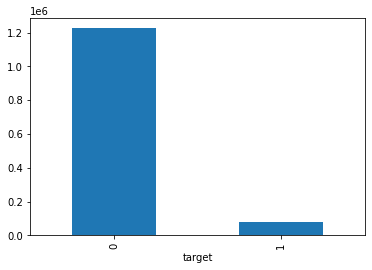

In [4]:
df.groupby('target').size().plot.bar()

<AxesSubplot:xlabel='question_text'>

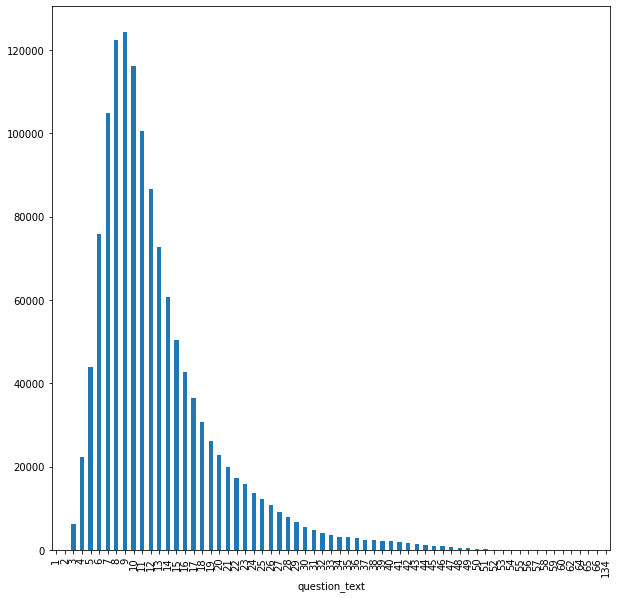

In [5]:
df.groupby(df['question_text'].map(lambda x: len(x.split()))).size().plot.bar(figsize=(10,10))

<AxesSubplot:xlabel='question_text'>

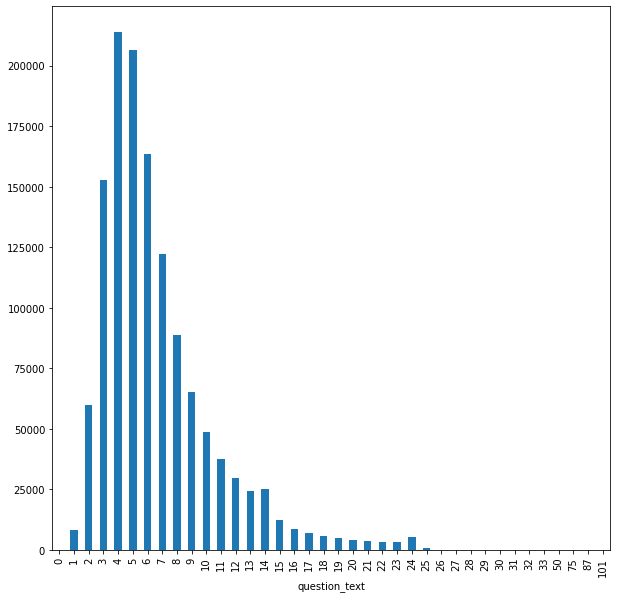

In [7]:
df.groupby(df['question_text'].map(lambda x: int(len(x)/10))).size().plot.bar(figsize=(10,10))

In [ ]:
df[df['target']==1].head()

In [ ]:
df[df['target']==1].groupby(df['question_text'].map(lambda x: int(len(x)/10))).size().plot.bar(figsize=(10,10))

In [ ]:
df[df['target']==0].groupby(df['question_text'].map(lambda x: int(len(x)/10))).size().plot.bar(figsize=(10,10))

In [ ]:
df[df['target']==1].groupby(df['question_text'].map(lambda x: len(x.split()))).size().plot.bar(figsize=(10,10))

In [ ]:
df[df['target']==0].groupby(df['question_text'].map(lambda x: len(x.split()))).size().plot.bar(figsize=(10,10))

# Часть 1. Tf-Idf

В этой части необходимо пройти классический путь решения задачи методом "мешок слов". Ваша задача:
1. Нормализовать данные (если нужно)
2. Выбрать вариант токенизации (начните с from nltk import word_tokenize и подумайте, достаточно ли его). Либо с помощью https://spacy.io/api/tokenizer/, если кажется, что нужно что-то большее.
3. Определитесь со списком стоп-слов.
4. Постройте конвейер (Pipeline), включающий в себя превращение текстов в векторы и непосредственно моделирование с помощью линейной модели.
5. Объясните предсказания вашей модели при помощи eli5.
5. Попробуйте подобрать лучшие параметры при помощи GridSearchCV или RandomizedSearchCV. Второй вариант НАМНОГО лучше, как вы уже успели убедиться в прошлом. Кроме того, тут вам нужно будет подбирать как параметры самой модели, так и параметры векторизатора (min_df и т.д.).
6. Попробуйте как можно сильнее сжать пространство признаков путем фильтрации редких слов, при этом старайтесь не потерять в качестве.

Ниже по пунктам подробнее. Не надо волноваться, если сразу что-то будет не получаться. Все ваши вопросы (в том числе и по kaggle) я ожидаю в канале в slack или в личке. 

In [28]:
#загрузка дополнительных данных для nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/natalliazzz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/natalliazzz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/natalliazzz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Задание 1.1 Нормализация и токенизация

Стоит быть честным и сказать, что тексты вопросов написаны очень хорошо, без шума, разделены в основном пробелами. Поэтому эта часть тривиальна. Поэтому, просто пощупайте и сравните 2 токенизатора.

In [29]:
from nltk.tokenize import word_tokenize

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer()
sklearn_tokenizer = vect.build_tokenizer()

In [31]:
print(df.question_text[1])
word_tokenize(df.question_text[1])

Do you have an adopted dog, how would you encourage people to adopt and not shop?


['Do',
 'you',
 'have',
 'an',
 'adopted',
 'dog',
 ',',
 'how',
 'would',
 'you',
 'encourage',
 'people',
 'to',
 'adopt',
 'and',
 'not',
 'shop',
 '?']

In [32]:
sklearn_tokenizer(df.question_text[1])

['Do',
 'you',
 'have',
 'an',
 'adopted',
 'dog',
 'how',
 'would',
 'you',
 'encourage',
 'people',
 'to',
 'adopt',
 'and',
 'not',
 'shop']

# Часть 1.2 Стоп-слова

ВНИМАНИЕ! ВНИМАТЕЛЬНО ЧИТАЙТЕ, ЧТО НУЖНО СДЕЛАТЬ В РАМКАХ ЗАДАНИЯ.

Токенизация должна быть согласована со стоп-словами. Т.е. токенизатор должен воспринимать стоп-слова как токены, а не как несколько токенов (не разбивать на несколько и не фильтровать). В этом задании вам нужно посмотреть на стоп-слова из nltk и проверить, являются ли два токенизатора выше согласованными со списком английских стоп-слов из nltk. Для этого попробуйте токенизировать по очереди все стоп-слова двумя текенизаторами и сделайте соответствующие выводы.

In [33]:
from nltk.corpus import stopwords

In [34]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [35]:
print(word_tokenize(df.question_text[1]))
print([w for w in word_tokenize(df.question_text[1]) if w not in stopwords.words('english')])

['Do', 'you', 'have', 'an', 'adopted', 'dog', ',', 'how', 'would', 'you', 'encourage', 'people', 'to', 'adopt', 'and', 'not', 'shop', '?']
['Do', 'adopted', 'dog', ',', 'would', 'encourage', 'people', 'adopt', 'shop', '?']


In [36]:
print(sklearn_tokenizer(df.question_text[1]))
print([w for w in sklearn_tokenizer(df.question_text[1]) if w not in stopwords.words('english')])

['Do', 'you', 'have', 'an', 'adopted', 'dog', 'how', 'would', 'you', 'encourage', 'people', 'to', 'adopt', 'and', 'not', 'shop']
['Do', 'adopted', 'dog', 'would', 'encourage', 'people', 'adopt', 'shop']


In [38]:
[word_tokenize(el) for el in stopwords.words('english')]

[['i'],
 ['me'],
 ['my'],
 ['myself'],
 ['we'],
 ['our'],
 ['ours'],
 ['ourselves'],
 ['you'],
 ['you', "'re"],
 ['you', "'ve"],
 ['you', "'ll"],
 ['you', "'d"],
 ['your'],
 ['yours'],
 ['yourself'],
 ['yourselves'],
 ['he'],
 ['him'],
 ['his'],
 ['himself'],
 ['she'],
 ['she', "'s"],
 ['her'],
 ['hers'],
 ['herself'],
 ['it'],
 ['it', "'s"],
 ['its'],
 ['itself'],
 ['they'],
 ['them'],
 ['their'],
 ['theirs'],
 ['themselves'],
 ['what'],
 ['which'],
 ['who'],
 ['whom'],
 ['this'],
 ['that'],
 ['that', "'ll"],
 ['these'],
 ['those'],
 ['am'],
 ['is'],
 ['are'],
 ['was'],
 ['were'],
 ['be'],
 ['been'],
 ['being'],
 ['have'],
 ['has'],
 ['had'],
 ['having'],
 ['do'],
 ['does'],
 ['did'],
 ['doing'],
 ['a'],
 ['an'],
 ['the'],
 ['and'],
 ['but'],
 ['if'],
 ['or'],
 ['because'],
 ['as'],
 ['until'],
 ['while'],
 ['of'],
 ['at'],
 ['by'],
 ['for'],
 ['with'],
 ['about'],
 ['against'],
 ['between'],
 ['into'],
 ['through'],
 ['during'],
 ['before'],
 ['after'],
 ['above'],
 ['below'],
 ['to'

In [39]:
[sklearn_tokenizer(el) for el in stopwords.words('english')]

[[],
 ['me'],
 ['my'],
 ['myself'],
 ['we'],
 ['our'],
 ['ours'],
 ['ourselves'],
 ['you'],
 ['you', 're'],
 ['you', 've'],
 ['you', 'll'],
 ['you'],
 ['your'],
 ['yours'],
 ['yourself'],
 ['yourselves'],
 ['he'],
 ['him'],
 ['his'],
 ['himself'],
 ['she'],
 ['she'],
 ['her'],
 ['hers'],
 ['herself'],
 ['it'],
 ['it'],
 ['its'],
 ['itself'],
 ['they'],
 ['them'],
 ['their'],
 ['theirs'],
 ['themselves'],
 ['what'],
 ['which'],
 ['who'],
 ['whom'],
 ['this'],
 ['that'],
 ['that', 'll'],
 ['these'],
 ['those'],
 ['am'],
 ['is'],
 ['are'],
 ['was'],
 ['were'],
 ['be'],
 ['been'],
 ['being'],
 ['have'],
 ['has'],
 ['had'],
 ['having'],
 ['do'],
 ['does'],
 ['did'],
 ['doing'],
 [],
 ['an'],
 ['the'],
 ['and'],
 ['but'],
 ['if'],
 ['or'],
 ['because'],
 ['as'],
 ['until'],
 ['while'],
 ['of'],
 ['at'],
 ['by'],
 ['for'],
 ['with'],
 ['about'],
 ['against'],
 ['between'],
 ['into'],
 ['through'],
 ['during'],
 ['before'],
 ['after'],
 ['above'],
 ['below'],
 ['to'],
 ['from'],
 ['up'],
 ['do

# Часть 1.3 Pipeline и процесс обучения

Когда в процессе моделирования есть несколько шагов, их бывает удобно объединить в конвейер. В sklearn это реализовано в классе Pipeline. Ниже вам представлен пример его использования.
Также в этой лабе мы будем пользоваться cross_val_predict, чтобы считать честные предсказанные вероятности. Для этого указан параметр method='predict_proba' в примере внизу. Как вы можете видеть, векторизатор и классификатор остались с параметрами по умолчанию. Ваша цель - **выбрать для них нормальные параметры и полностью разбираться в том, что они значат** на основе знаний, которые вы получили на всех прошлых занятиях. На практике у вас обязательно будут спрашивать про эти параметры, а также про то, как работает TfIdfVectorizer и SGDClassifier. Типичные вопросы, ответы на которые необходимо знать для хорошей оценки:
1. Что такое стохастический градиентный спуск?
2. Как обучается и делает предсказания логистическая регрессия?
3. Что такое tf-idf и зачем это нужно?
4. Что такое кросс-валидация? Как производится кросс-валидация классом StratifiedKFold?

И, конечно же, многие другие вопросы. Аналогичные вопросы будут и к другим пунктам лабы.



In [2]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold


In [24]:
vect = TfidfVectorizer(stop_words='english', max_df = 0.5)
clf = SGDClassifier(loss= 'modified_huber',random_state = 42, class_weight = 'balanced', alpha = 1e-6)
model = Pipeline([('vect', vect), ('clf', clf)])


In [25]:
model.fit(df.question_text, df.target)

Pipeline(steps=[('vect', TfidfVectorizer(max_df=0.5, stop_words='english')),
                ('clf',
                 SGDClassifier(alpha=1e-06, class_weight='balanced',
                               loss='modified_huber', random_state=42))])

In [43]:
%%time
preds = cross_val_predict(model, df.question_text.values, df.target.values,
                          cv=StratifiedKFold(5), n_jobs=-1,
                          method='predict_proba')

CPU times: user 1min 44s, sys: 1.93 s, total: 1min 46s
Wall time: 1min 45s


In [26]:
preds2 = cross_val_predict(model, df.question_text.values, df.target.values,
                          cv=StratifiedKFold(5), n_jobs=-1,
                          method='predict')

In [ ]:
preds

В соревновании результаты ранжируются по метрике F1 (обязательно спрошу ее формулу!!). Но мы локально будет считать также roc_auc_score и делать classification_report. Не забудьте указать либо подобрать решающую границу(порог принятия решения) для максимизации метрик перед подачей предсказаний в эту функцию.


In [10]:
from sklearn.metrics import roc_auc_score, classification_report, f1_score

In [46]:
roc_auc_score(df.target, preds[:,1])

0.9431682388700173

In [48]:
print(classification_report(df.target, [1 if i[0] < i[1] else 0 for i in preds ]))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94   1225312
           1       0.35      0.86      0.50     80810

    accuracy                           0.89   1306122
   macro avg       0.67      0.88      0.72   1306122
weighted avg       0.95      0.89      0.91   1306122



In [ ]:
classification_report(df.target, [1 if i[0] < i[1] else 0 for i in preds ])

In [27]:
f1_score(df.target, preds2)

0.4954630616068476

# Часть 1.4 Объяснение предсказаний при помощи eli5

Используйте функционал eli5, чтобы посмотреть, как работает ваша модель, сделайте выводы. Для этого прочтите соответствующий туториал на странице https://eli5.readthedocs.io/en/latest/tutorials/sklearn-text.html 

Тем, кто больше любит видосы, можно посмотреть выступление от одного из авторов библиотеки https://www.youtube.com/watch?v=9vYkwD0feb4

Спрашивать буду обязательно, так что разобраться придется. Необходимо вспомнить, что означают веса линейных моделей и как с их помощью объяснять предсказания.

In [28]:
import eli5

In [29]:
eli5.show_weights(clf, top=10)

In [30]:
eli5.show_weights(clf, vec=vect, top=10,
                  target_names=df.target)

In [31]:
eli5.show_prediction(clf, df.question_text[22], vec=vect,
                     target_names=df.target)

In [32]:
eli5.show_prediction(clf, df.question_text[114], vec=vect,
                     target_names=df.target)

# Часть 1.5 Стемминг и лемматизация

Проведите для текстов стемминг и лемматизацию. Поскольку это процесс не быстрый, лучше сохранить предобработанные тексты в отдельный столбец DataFrame. Обучите модель на стеммированных и лемматизированных данных, сравните размер словаря

In [33]:
from nltk.stem import SnowballStemmer, WordNetLemmatizer, LancasterStemmer

In [34]:
from functools import lru_cache

In [35]:
# эта вспомогательная функция поможет вам чуть быстрее пройтись по всему тексту
# обратите внимание, что лемматизация будет в основном работать только для слов в нижнем регистре!

LEMMATIZER = WordNetLemmatizer()

@lru_cache(maxsize=2048)
def lemmatize_word(word):
    parts = ['a','v','n','r']
    for part in parts:
        temp = LEMMATIZER.lemmatize(word, part)
        if temp != word:
            return temp
    return word    

In [36]:
stemmer = SnowballStemmer('english')

In [124]:
print(lemmatize_word('having'))
print(stemmer.stem('having'))

have
have


In [125]:
print(stemmer.stem('tolerant'))
print(stemmer.stem('tolerable'))

toler
toler


In [126]:
print(df.question_text[1])
print(" ".join([stemmer.stem(i) for i in df.question_text[1].split()]))
print(" ".join([lemmatize_word(i) for i in df.question_text[1].split()]))

Do you have an adopted dog, how would you encourage people to adopt and not shop?
do you have an adopt dog, how would you encourag peopl to adopt and not shop?
Do you have an adopt dog, how would you encourage people to adopt and not shop?


In [37]:
df["stemmed"] = df.question_text.apply(lambda x: " ".join([stemmer.stem(i) for i in x.split()]))

In [38]:
df["lemmatized"] = df.question_text.apply(lambda x: " ".join([lemmatize_word(i) for i in x.split()]))

In [ ]:
df.head()

In [60]:
df.lemmatized[1]

'Do you have an adopt dog, how would you encourage people to adopt and not shop?'

In [89]:
vect_s = TfidfVectorizer(stop_words='english', max_df = 0.5)
clf_s = SGDClassifier(loss= 'modified_huber',random_state = 23, alpha = 1e-6, epsilon = 1e-6,max_iter = 10000)
model_stemmed= Pipeline([('vect', vect_s), ('clf', clf_s)])

In [90]:
model_stemmed.fit(df.stemmed, df.target)

Pipeline(steps=[('vect', TfidfVectorizer(max_df=0.5, stop_words='english')),
                ('clf',
                 SGDClassifier(alpha=1e-06, epsilon=1e-06,
                               loss='modified_huber', max_iter=10000,
                               random_state=13))])

In [91]:
preds_stemmed = cross_val_predict(model_stemmed, df.stemmed.values, df.target.values,
                          cv=StratifiedKFold(5), n_jobs=-1,
                          method='predict')

In [92]:
f1_score(df.target,preds_stemmed)

0.5189195756669123

In [121]:
roc_auc_score(df.target, preds_stemmed[:,1])

0.9425363585301128

In [59]:
eli5.show_weights(clf_s, vec=vect_s, top=10,
                  target_names=df.target)

In [120]:
print(classification_report(df.target, [1 if i[0] < i[1] else 0 for i in preds_stemmed ]))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94   1225312
           1       0.34      0.86      0.49     80810

    accuracy                           0.89   1306122
   macro avg       0.66      0.88      0.71   1306122
weighted avg       0.95      0.89      0.91   1306122



In [88]:
f1_score(df.target,preds_stemmed)

0.5211309052221744

In [69]:
test = pd.read_csv('test.csv')

In [70]:
test["stemmed"]= test.question_text.apply(lambda x: " ".join([stemmer.stem(i) for i in x.split()]))

In [72]:
model_stemmed.predict(test["stemmed"])

array([1, 0, 0, ..., 0, 0, 1])

In [44]:
vect_l = TfidfVectorizer(stop_words='english', max_df = 0.5)
clf_l = SGDClassifier(loss= 'modified_huber',random_state = 23, alpha = 1e-6, epsilon = 1e-6,max_iter = 10000)
model_lemmatized = Pipeline([('vect', vect_l), ('clf', clf_l)])

In [45]:
model_lemmatized.fit(df.stemmed, df.target)

Pipeline(steps=[('vect', TfidfVectorizer(max_df=0.5, stop_words='english')),
                ('clf',
                 SGDClassifier(alpha=1e-06, class_weight='balanced',
                               loss='modified_huber', random_state=42))])

In [47]:
preds_lemmatized = cross_val_predict(model_lemmatized, df.lemmatized.values, df.target.values,
                          cv=StratifiedKFold(5), n_jobs=1,
                          method='predict')

In [49]:
eli5.show_weights(clf_l, vec=vect_l,top=10,
                  target_names=df.target)

In [118]:
roc_auc_score(df.target, preds_lemmatized[:,1])

0.9412407937986396

In [115]:
eli5.show_weights(clf_l, vec=vect_l)

In [69]:
print(classification_report(df.target, [1 if i[0] < i[1] else 0 for i in preds_lemmatized]))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94   1225312
           1       0.34      0.86      0.49     80810

    accuracy                           0.89   1306122
   macro avg       0.66      0.87      0.71   1306122
weighted avg       0.95      0.89      0.91   1306122



In [48]:
f1_score(df.target, preds_lemmatized)

0.4889203052217571

# Часть 1.5 Оптимизация модели

Подберите с помощью GridSearch или RandomizedSearch хорошие параметры вашей модели. Когда вы делаете сетку для пайплайна параметры надо называть так как у внутреннего класса, добавляя названия соответствующего этапа перед ними. Например:

In [70]:
grid = {'clf__loss': ['hinge','log','modified_huber',"squared_hinge","perceptron"],
        'clf__penalty': ['l1','l2','elasticnet'],
        'clf__epsilon': [0.1,0.2,0.5],
        'clf__alpha': np.arange(0.0001,0.0005,0.0001),
        'clf__class_weight': [None,'balanced'],
        'vect__lowercase': [True, False],
        'vect__analyzer': ['word', 'char', ' char_wb'],
        'vect__decode_error': ['strict','ignore','replace'],
        'vect__max_df': np.arange(0.0,1.0,0.1),
        'vect__min_df': np.arange(0.0,1.0,0.1)
        }

Попробуйте разные функции ошибок для SGD. Например hinge (внутри получится svm, нельзя будет предсказывать вероятности), modified_huber - комбинация l1 и l2 ошибки для классификации (упоминалась на одной из прошлых лекций). 
Разную предобработку, параметры, подберите порог принятия решения.

Попробуйте уменьшать размер словаря путем комбинации лемматизации (или стемминга) и увеличения min_df. Проанализируйте, как меняется размер словаря, а также качество модели.

In [71]:
from sklearn.model_selection import RandomizedSearchCV

In [72]:
vect_e = TfidfVectorizer()
clf_e = SGDClassifier()

In [73]:
search = RandomizedSearchCV(Pipeline([('vect', vect_e), ('clf', clf_e)]), param_distributions=grid,cv=StratifiedKFold(5), n_jobs=1)

In [74]:
search.fit(df.lemmatized.values, df.target.values)

/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/p

/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/p

/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/p

/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/p

/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/p

/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **kwargs)
  File "/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/p

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                             ('clf', SGDClassifier())]),
                   n_jobs=1,
                   param_distributions={'clf__alpha': array([0.0001, 0.0002, 0.0003, 0.0004]),
                                        'clf__class_weight': [None, 'balanced'],
                                        'clf__epsilon': [0.1, 0.2, 0.5],
                                        'clf__loss': ['hinge', 'log',
                                                      'modified_huber',
                                                      'squared_hinge',
                                                      'perceptron'],
                                        'clf__penalty': ['l1', 'l2',
                                                         'elasticnet'],
                                        'vect__analyzer': ['word', 

In [76]:
best_rand = search.best_estimator_

In [77]:
pred_rand = cross_val_predict(best_rand,df.question_text.values, df.target.values,
                          cv=StratifiedKFold(5, random_state=42,shuffle = True), n_jobs=1,
                          method='predict')

In [78]:
f1_score(df.target.values, pred_rand)

0.0

# Часть 2 (На 10). Тематическое моделирование

Используйте либо https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html, либо модели из gensim (https://radimrehurek.com/gensim/models/ldamodel.html) для тематического моделирования на этих текстах. Посмотрите на полученные темы, попытайтесь их интерпретировать. Используйте распределение тем для документа в качестве набора признаков, описывающих его. Обучите модель на этих признаках и сравните с tf-idf.

Поскольку задание на 10 тут не будет никакой дополнительной информацию. Те, кто делают, пусть пишут мне сообщения и задают вопросы на паре. Отвечу и помогу точечно.

In [8]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

In [9]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


In [10]:
lda = LatentDirichletAllocation(max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0)

In [11]:
tf_vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, stop_words="english", max_features = 1000
)

In [12]:
tf = tf_vectorizer.fit_transform(df.question_text)

In [13]:
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, random_state=0)

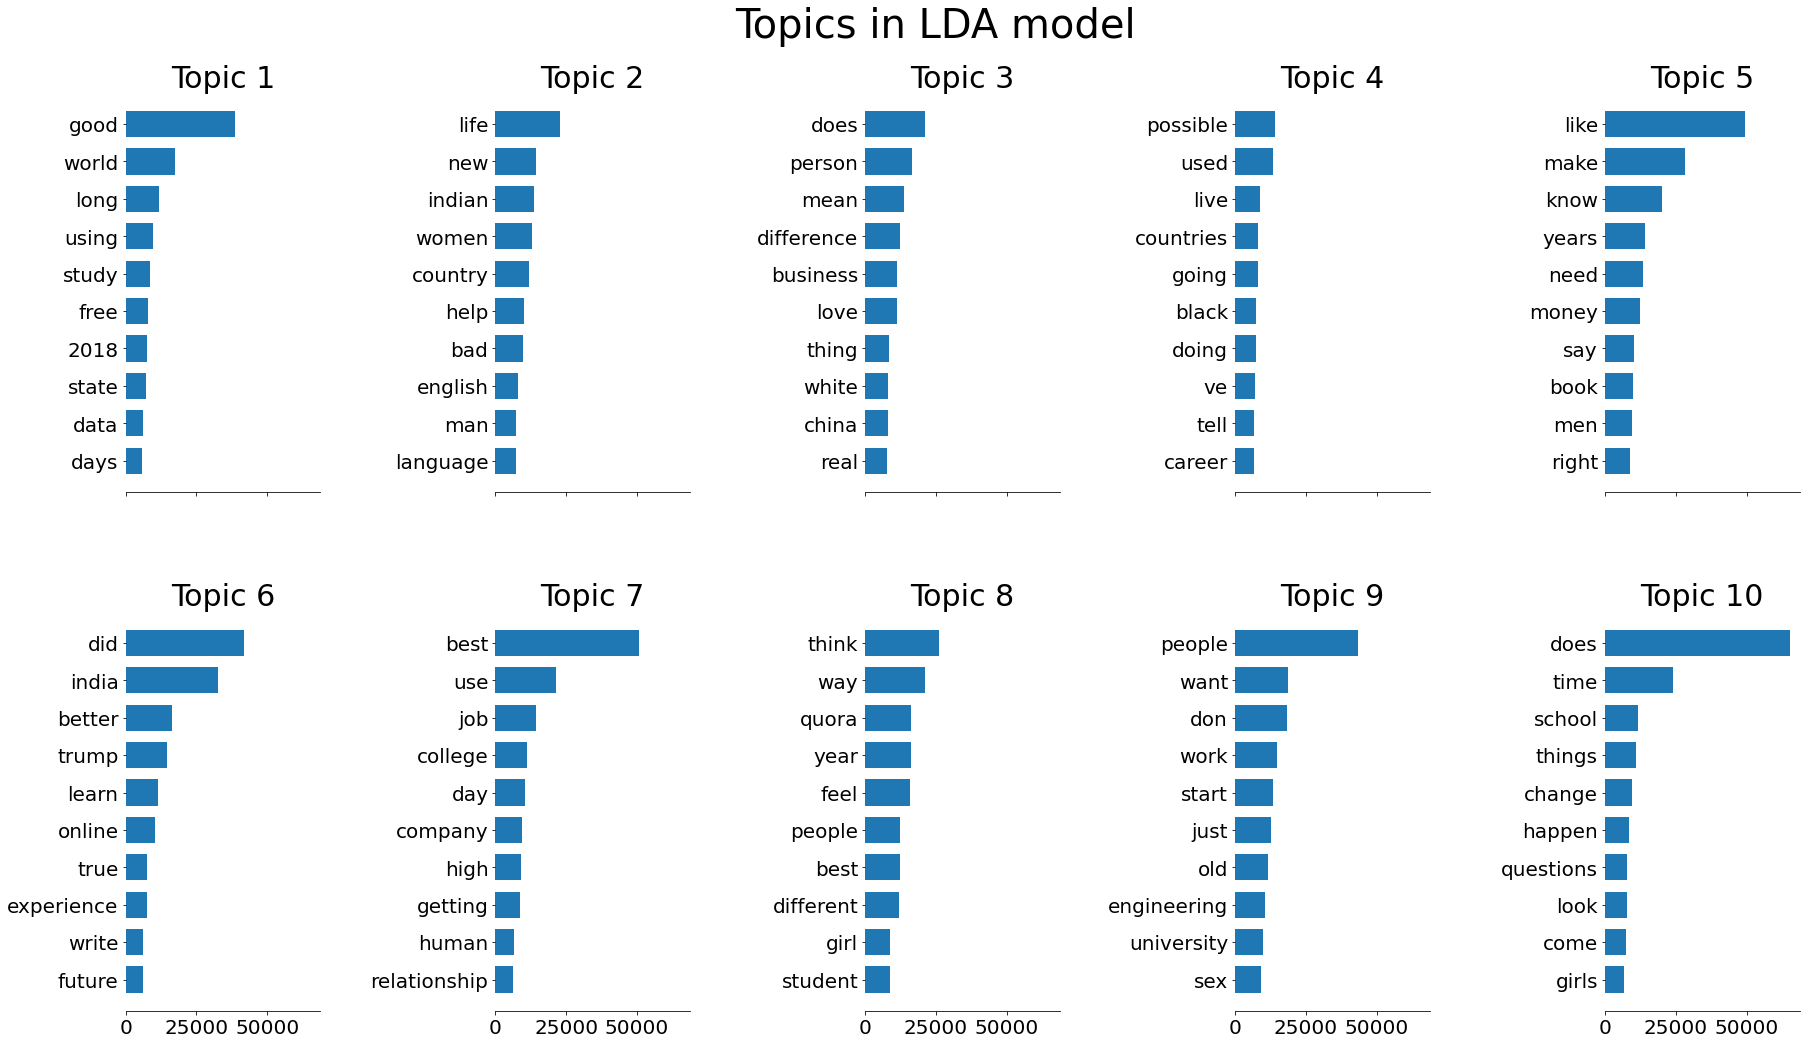

In [16]:
tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, 10, "Topics in LDA model")

In [17]:
trans = lda.transform(tf)

In [20]:
class10 = SGDClassifier(loss= 'modified_huber')

In [21]:
class10.fit(trans,df.target)

SGDClassifier(loss='modified_huber')

In [22]:
preds10 = cross_val_predict(class10, trans, df.target.values,
                          cv=StratifiedKFold(5), n_jobs=1,
                          method='predict_proba')

In [79]:
print(classification_report(df.target, [1 if i[0] < i[1] else 0 for i in preds10 ]))

/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.94      1.00      0.97   1225312
           1       0.00      0.00      0.00     80810

    accuracy                           0.94   1306122
   macro avg       0.47      0.50      0.48   1306122
weighted avg       0.88      0.94      0.91   1306122



/Users/natalliazzz/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [122]:
eli5.show_weights(class10, top=10)

# Часть 3. word2vec

В этой части вам надо будет пощупать вектора слов, поискать ассоциации, а потом использовать эти вектора как признаки для вашей модели.


Скачайте векторы отсюда и загрузите их при помощи кода ниже.

https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download


Если ваш компьютер не позволяет загрузить большие векторы, воспользуйтесь векторами вот отсюда. Они будут в 10 раз меньше по размеру.

https://github.com/eyaler/word2vec-slim/blob/master/GoogleNews-vectors-negative300-SLIM.bin.gz

Для работы с большими векторами нужно как минимум 8 гб оперативной памяти. Если у вас их нет, то пользуйтесь маленькими, либо google colaboratory, либо kaggle kernels.

In [4]:
from gensim.models import KeyedVectors

In [5]:
w2v = KeyedVectors.load_word2vec_format('/Users/natalliazzz/Downloads/GoogleNews-vectors-negative300.bin', binary=True)

# Задание 3.1 Знакомство с векторами

Пощупайте векторы и найдите по крайней мере 2 **семантических** и 2 **синтаксических** аналогии

In [82]:
# вот так можно получить вектор слова
len(w2v['Minsk'])

300

In [123]:
w2v['Trump']

array([-2.55126953e-02,  7.75146484e-03, -6.12792969e-02, -1.47705078e-02,
        9.42382812e-02, -1.07910156e-01,  5.02929688e-02,  1.84570312e-01,
        3.08593750e-01, -3.56445312e-02,  5.59082031e-02, -1.61132812e-01,
       -2.73437500e-01,  1.00097656e-01, -2.48046875e-01,  8.93554688e-02,
        1.13525391e-02, -2.41699219e-02,  5.15136719e-02, -3.39843750e-01,
       -1.58203125e-01, -2.14843750e-01,  4.64843750e-01,  3.92578125e-01,
       -7.41577148e-03,  3.06640625e-01, -2.08984375e-01, -4.85839844e-02,
        2.55859375e-01, -2.48046875e-01, -9.42382812e-02,  1.94335938e-01,
       -3.63281250e-01, -1.16699219e-01,  7.86132812e-02,  5.15136719e-02,
        1.76757812e-01,  4.34570312e-02, -2.69531250e-01, -2.27539062e-01,
        2.22656250e-01, -1.78710938e-01,  2.75390625e-01,  5.07812500e-01,
       -3.22265625e-01, -2.22656250e-01,  1.91406250e-01,  2.43164062e-01,
        2.79541016e-02,  2.39257812e-01, -1.15234375e-01,  2.24609375e-01,
       -6.12792969e-02, -

Вот так работают аналогии

In [83]:
# vec(Minsk) - vec(Belarus) + vec(Russia) ~= vec(Moscow)
w2v.most_similar(positive=['Minsk', 'Russia'], negative=['Belarus'])

[('Moscow', 0.7905825972557068),
 ('Tbilisi', 0.6598107218742371),
 ('Kyiv', 0.6513273119926453),
 ('Kremlin', 0.6477817893028259),
 ('Kiev', 0.6403970122337341),
 ('Saint_Petersburg', 0.635554850101471),
 ('St_Petersburg', 0.6216074824333191),
 ('Baku', 0.618080198764801),
 ('Vilnius', 0.6057642698287964),
 ('Putin', 0.5993437170982361)]

In [84]:
w2v.similarity('woman', 'man')

0.76640123

In [85]:
print(df.question_text[1])
print(df.question_text[2])
w2v.wmdistance(df.question_text[1].lower().split(), df.question_text[2].lower().split())

Do you have an adopted dog, how would you encourage people to adopt and not shop?
Why does velocity affect time? Does velocity affect space geometry?


1.1650526539393498

In [ ]:
w2v.most_similar(positive=['Trump'])

In [ ]:
w2v.most_similar(positive=['dog'], negative = ['Trump','jew'])

In [ ]:
w2v.most_similar(positive= ['Trump','jew'])

# Задание 3.2 Использование среднего вектора в качестве фичей для моделирования

Как мы и говорили на лекции, вектора слов можно использовать для построения признакового описания текста путем усреднения векторов. Сделайте это. Для этого нужно:
1. Токенизировать каждый текст
2. Для каждого токена попробовать найти вектор в w2v. Если его там нет, то просто игнорировать.
3. Усреднить все вектора слов текста для получения его признакового описания. Если ни одного из слов в тексте нет вектора, то вернуть вектор из нулей той же длины

На полученных признаках обучите модель для предсказания и сравните качество.

ВНИМАНИЕ! Не забывайте нормировать вектора с помощью numpy!



In [6]:
def vectorize(sent):
    i = len(sent)
    vect = []
    for i in sent.split():
        try:
            vect.append(w2v[i])
        except:
            continue
            
    if len(vect) == 0:
        return np.zeros(300)
    vector = np.mean(vect, axis=0)
    return list(vector / np.linalg.norm(vector))
    

In [10]:
from sklearn.model_selection import cross_val_predict, cross_val_score, \
    GridSearchCV, RandomizedSearchCV, train_test_split, KFold

In [ ]:
df = df[["qid","question_text","target","stemmed","lemmatized"]]

In [7]:
vectors = df.question_text.apply(lambda x: vectorize(x))

In [ ]:
vector = df.question_text.apply(lambda x: vectorize(x))

In [35]:
classif = SGDClassifier(loss= 'modified_huber')

In [20]:
grid = {'penalty': ['elasticnet'],
        'loss': ['huber','modified_huber'],
    }

In [31]:
search = GridSearchCV(SGDClassifier(random_state=33,shuffle=True,n_jobs=-1), param_grid=grid, return_train_score=True,
                      cv=KFold(2, random_state=33,shuffle=True), verbose=1,
                      scoring='neg_mean_absolute_error')

Fitting 2 folds for each of 2 candidates, totalling 4 fits


KeyboardInterrupt: 

In [89]:
classif.fit(list(vectors.values),df.target)

SGDClassifier(loss='modified_huber')

In [28]:
df.tar[::1000].values)

[[0.0076917503,
  0.059020165,
  0.0752174,
  0.15137625,
  -0.025381899,
  -0.054873828,
  0.034272358,
  -0.06869494,
  0.05137661,
  0.0135669755,
  -0.041288074,
  -0.04745249,
  -0.010651271,
  0.006580052,
  -0.13075975,
  0.042514946,
  0.016159687,
  0.09772992,
  0.040862422,
  -0.036320485,
  0.022202354,
  0.012949782,
  -0.008628181,
  -0.013861801,
  0.021925993,
  0.024597576,
  -0.07549407,
  0.028072884,
  0.047351085,
  0.03244957,
  0.032689936,
  0.01823786,
  -0.07946139,
  0.042938095,
  0.030368892,
  0.025203502,
  -0.015740296,
  0.056521345,
  0.0822857,
  0.028017174,
  0.018989008,
  -0.024189452,
  0.17969452,
  -0.03442008,
  -0.015438585,
  0.04511517,
  -0.05239003,
  0.0674931,
  -0.006119348,
  0.057397682,
  0.004036166,
  0.015428569,
  -0.015949365,
  0.039961044,
  -0.08740352,
  0.06647592,
  -0.16722545,
  0.009935177,
  0.002418695,
  0.005989149,
  0.008723326,
  0.09249129,
  -0.08532911,
  -0.07896063,
  -0.010320766,
  0.012531644,
  -0.02953

In [ ]:
np.save('vectors',vectors)

In [91]:
pre = cross_val_predict(classif, list(vectors.values), df.target.values,
                          cv=StratifiedKFold(5), n_jobs=1,
                          method='predict')

In [92]:
print(classification_report(df.target, [1 if i[0] < i[1] else 0 for i in pre ]))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97   1225312
           1       0.68      0.26      0.38     80810

    accuracy                           0.95   1306122
   macro avg       0.82      0.63      0.68   1306122
weighted avg       0.94      0.95      0.94   1306122



# Часть 4 (На 9). Давайте используем Transformers как полностью черный ящик и сравним качество 

Давайте теперь попробуем взять вектора слов из другого источника. В этом нам поможет библиотека sentence_transformers, которую вам нужно установить следующим образом:
1. conda install -c conda-forge sentence-transformers
2. Если при загрузке модели у вас вываливаются ошибки, в которых что-то говорится о несовместимых версиях файлов, то убедитесь, что вас установился pytorch версии 1.6 или выше с помощью conda list. Обновите, если вдруг это не так. 
3. Если кто-то является счастливым обладателем игровой видеокатры, то пусть выполняет эти вычисления на gpu. Остальным рекомендую или считать на kaggle kernels/google colaboratory, или сэмплировать данные, чтобы их было меньше.


Документация к библиотеке вот тут: https://www.sbert.net/docs/quickstart.html

In [127]:
from sentence_transformers import SentenceTransformer

В качестве векторизатора возьмем модель, которую авторы библиотеки рекомендуют по умолчанию. Во время первого выполнения ячейки файл с весами модели будет скачан вам на компьютер.

В дальнейшем используйте model.encode, чтобы преобразовать ваши тексты в вектора. Обратите внимание, что токенизация происходит внутри без вашего участия. Вы просто подаете тексты.

В инициализации ниже указана модель all-mpnet-base-v2. Для скорости можно взять модель полегче. Например, all-MiniLM-L6-v2. Список моделей вот тут: https://www.sbert.net/docs/pretrained_models.html 


Если будет выпадать ошибка "ImportError: IProgress not found. Please update jupyter and ipywidgets. See 
https://ipywidgets.readthedocs.io/en/stable/user_install.html", то установите их с помощью **conda install ipywidgets**

In [129]:
model = SentenceTransformer('all-mpnet-base-v2')

Задания следующие:

- Преобразуйте все тексты в признаки (их должно быть 768 для каждого текста). Обучите SGDClassifer на этих признаках и сравните качество с предыдущими вариантами.

- Попробуйте поискать с помощью модели похожие вопросы как показано в sbert quickstart (ссылка выше).

In [ ]:
# encoded = model.encode(df.question_text)

In [ ]:
# np.save('data', encoded)

In [93]:
encoded = np.load('data.npy')

In [137]:
encoded.shape

(1306122, 768)

In [140]:
encoded[::1000,:].shape

(1307, 768)

In [37]:
search.fit(encoded[::1000,:],df.target[::1000])

Fitting 2 folds for each of 2 candidates, totalling 4 fits


GridSearchCV(cv=KFold(n_splits=2, random_state=33, shuffle=True),
             estimator=SGDClassifier(n_jobs=-1, random_state=33),
             param_grid={'loss': ['huber', 'modified_huber'],
                         'penalty': ['elasticnet']},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [38]:
search.best_estimator_

SGDClassifier(loss='huber', n_jobs=-1, penalty='elasticnet', random_state=33)

In [94]:
class9 = SGDClassifier(loss= 'modified_huber',random_state = 23, alpha = 1e-6, epsilon = 1e-9,max_iter = 10000)

In [95]:
class9.fit(encoded,df.target)

SGDClassifier(alpha=1e-06, epsilon=1e-09, loss='modified_huber', max_iter=10000,
              random_state=23)

In [96]:
pre9 = cross_val_predict(class9, list(encoded[::111,:]), df.target[::111].values,
                          cv=StratifiedKFold(5), n_jobs=1,
                          method='predict')

In [97]:
print(f1_score(df.target[::111].values, pre9))

0.48915482423335827


## transformers

In [168]:
df_ds = df[['question_text','target']].to_xarray()

In [156]:
from transformers import BertTokenizer,BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

{'input_ids': tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [178]:
df[::1000].question_text

0          How did Quebec nationalists see their province...
1000       What is that one life changing novel that you ...
2000       Do you know anyone from LNMIIT who has given S...
3000       What challenges did Edward Hicks face as an Am...
4000       What is the purpose of the teaching carried ou...
                                 ...                        
1302000    Do all psychopaths have the tendency to kill? ...
1303000    Why does the amp in my blog template always wr...
1304000    Should I inform the university at which I am a...
1305000    Cheesecake Recipe calls for sour cream but I w...
1306000    What comic artists were notable for their use ...
Name: question_text, Length: 1307, dtype: object

In [180]:
example = df[::1000].question_text.apply(lambda x: tokenizer(x, padding="max_length", truncation=True))

In [193]:
train_example = example.apply(lambda x: x['input_ids']).to_list()

In [189]:
class9_2 = SGDClassifier(loss= 'modified_huber')

In [194]:
class9_2.fit(train_example,df.target[::1000])

SGDClassifier(loss='modified_huber')

In [195]:
pre9_2 = cross_val_predict(class9_2, train_example[::2], df.target[::2000].values,
                          cv=StratifiedKFold(5), n_jobs=1,
                          method='predict_proba')

In [196]:
print(classification_report(df.target[::2000], [1 if i[0] < i[1] else 0 for i in pre9_2 ]))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       620
           1       0.05      0.06      0.05        34

    accuracy                           0.89       654
   macro avg       0.50      0.50      0.50       654
weighted avg       0.90      0.89      0.90       654



# Задание 5 (На +1 к лабораторной по кластеризации). Кластеризация текстов на основе векторизации

Возьмите какую-то из векторизаций текстов на выбор и проведите для них кластеризацию способами из прошлой лабы по всем правилам. Попробуйте объяснить найденные кластеры, если они получатся и представить результат преподавателю. Если кластеризация не выходит, то обоснуйте это метриками и графиками.

P.S. Если у вас и так 10 за кластеризацию, то плюс можно будет добавить к любой лабе. Если у вас 10 за все лабы, то я вами горжусь!

In [93]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, homogeneity_score

In [96]:
kmeans_mnist = KMeans(n_clusters = 10,init = 'random', random_state=10)
labels = kmeans_mnist.fit_predict(list(vectors.values[::150]))

In [100]:
print("silhouette score: "+ str(silhouette_score(list(vectors.values)[::150],labels)))

silhouette score: 0.008563981


In [106]:
import matplotlib.cm as cm

In [101]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram,linkage

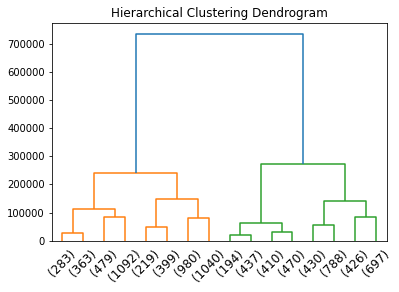

<Figure size 720x720 with 0 Axes>

In [102]:
model = AgglomerativeClustering(n_clusters=10)
model = model.fit(list(vectors.values[::150]))
plt.title('Hierarchical Clustering Dendrogram')
Z = linkage(model.children_, 'ward')
dendrogram(Z,truncate_mode='level', p = 3)
# plot_dendrogram(model,labels=model.labels_,truncate_mode='level', p = 5)
plt.tick_params(axis='x', rotation=45)
plt.figure(figsize=(10,10))
plt.show()

In [103]:
def kmeans_analysis(nclusters,X, y = [None]):
    fig, ax1 = plt.subplots()
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (nclusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=nclusters,init = 'random', random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        nclusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(nclusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / nclusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

For n_clusters = 5 The average silhouette_score is : 0.029431092


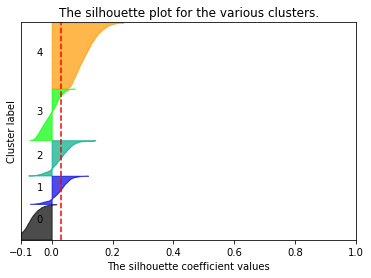

For n_clusters = 6 The average silhouette_score is : 0.0052480195


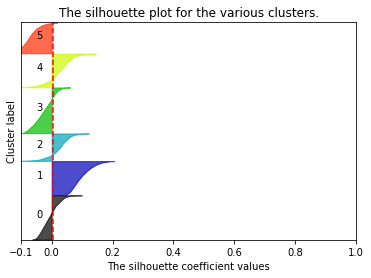

For n_clusters = 7 The average silhouette_score is : 0.006913451


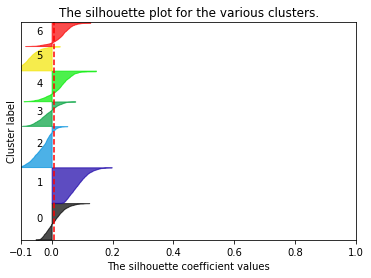

For n_clusters = 8 The average silhouette_score is : 0.008360977


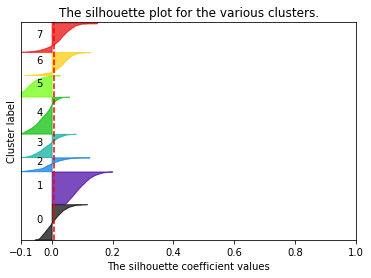

For n_clusters = 9 The average silhouette_score is : 0.008439668


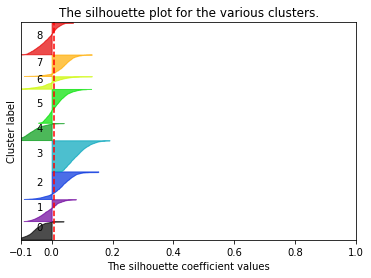

For n_clusters = 10 The average silhouette_score is : 0.008563981


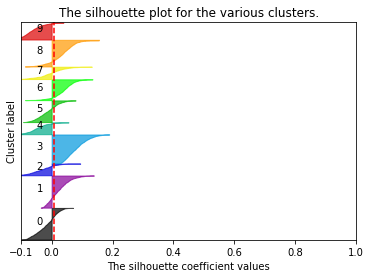

For n_clusters = 11 The average silhouette_score is : 0.0026476423


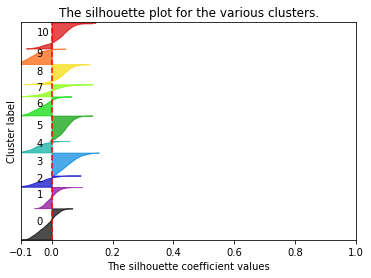

For n_clusters = 12 The average silhouette_score is : 0.0020831854


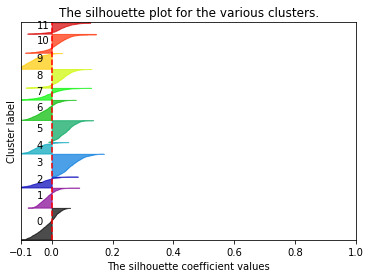

For n_clusters = 13 The average silhouette_score is : 0.0047815787


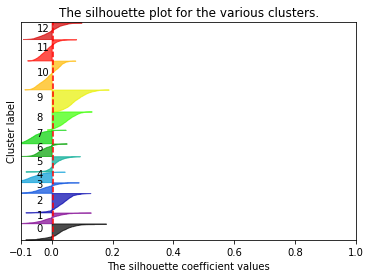

For n_clusters = 14 The average silhouette_score is : 0.0035657082


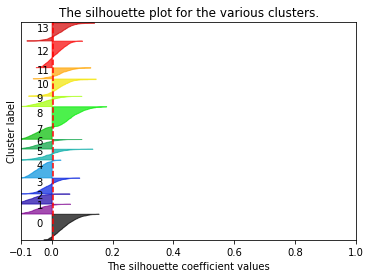

For n_clusters = 15 The average silhouette_score is : 0.005060559


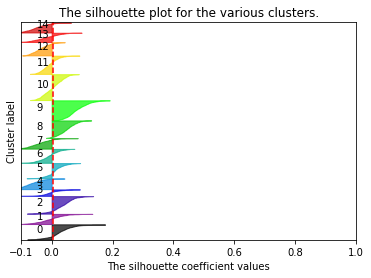

In [107]:
for i in range(5,16):
    kmeans_analysis(i,list(vectors.values[::150]))